# Biotype exploration

compare the top gene transcript between day 5, control, 'exo vs bulk' bio types

## load  transcipt level count and bio type data
data files created by extraCellularRNA/R/notebooks/kras.ipsc_exo_vs_bulk.DESeq.Rmd

the original data came was produced Using Salmon. 

### ??? 5/23/2020
The fileDESeq.ctrl.sampleType_ex0_vs_bulk.downRegulatedCounts.csv was missing. Looking at the up requlated file.
It looks like it the file has just been renamed?

```
(base) $ wc -l *up*
    4445 DESeq.ctrl.sampleType_ex0_vs_bulk.50.upRegulatedCounts.csv
    4445 DESeq.ctrl.sampleType_ex0_vs_bulk.upRegulatedCounts.csv
    8890 total
(base) $ diff *up*
```

fix: created a symbolic link
```
DESeq.ctrl.sampleType_ex0_vs_bulk.downRegulatedCounts.csv@ -> DESeq.ctrl.sampleType_ex0_vs_bulk.50.downRegulatedCounts.csv
```

## TODO
- salmon quant.sf files have biotype information. Should we use the count values in quant.sf files or use the 'normalized counts' from tximport/DESeq? They are normalized for library size

- start "parameterizing" notebook using a dictionary. This is not a good use of time there are only 3 data sets
    * cntrl bulk
    * cntrl exo
    * kras bulk
    
So far we only have DESeq for control exo vs bulk. Need DEseq for kras bulk vs control bulk

In [40]:
from   bme263DataVis.utilities import MatPlotLibUtilities
from   bme263DataVis.plotCumulativeProbablty import PlotCumulativeProbablity
from   bme263DataVis.plotProbMassFunc import PlotProbMass

# https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
# display(HTML(' <span style="color:red">the title is: <h1>Hello, world!</h1> </span>  '))
# display(HTML(df.to_html()))
from IPython.display import display, HTML

from   kimLabDataFactory.bioTypeCountFactor import BioTypeCountFactory
from   kimLabDataFactory.transcriptBioTypeCountFactory import TranscriptBioTypeCountFactory
from   kimLabStats.kullbackLeiblerDivergenceMonteCarlo import KullbackLeiblerDivergenceMonteCarlo as kldMonteCarlo
from   kimLabStats.monteCarlo import MonteCarlo
# from   kimLabStats.monteCarloUtils import kolmogorovSmirnovStat, kullbackLeiblerStat, shuffleParallelList
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   scipy.stats import entropy
from   scipy.stats import ks_2samp

mplu = MatPlotLibUtilities()
mplu.loadStyle()

macbookpro = "../data/R/output"
courtyard = "../R/output"
# biodataRootDir = courtyard
biodataRootDir = macbookpro

np.random.seed(42)

FILES_KEY         = "FILES_KEY"
SAMPLE_TYPE_KEY   = "SAMPLE_TYPE_KEY"
DOWN_CSV_FILE_KEY = "DOWN_CSV_FILE_KEY"
UP_CSV_FILE_KEY   = "UP_CSV_FILE_KEY"

# controlParameters[REF_FILES_KEY]              = !ls $biodataRootDir/*bulk*ctrl*biotype*
# controlParameters[REF_SAMPLE_TYPE_KEY]        = "bulk"
# controlParameters[DEPENDET_FILES_KEY]         = !ls $biodataRootDir/*exo*ctrl*biotype*
# controlParameters[DEPENDENT_SAMPLE_TYPE_KEY]  = "exo"

# three day 5 kras.ipcs data sets
bulkCntrlParams = dict()
exoCntrlParams  = dict()
bulkKrasParams  = dict()


bulkCntrlParams[FILES_KEY]       = !ls $biodataRootDir/*bulk*ctrl*biotype*
bulkCntrlParams[SAMPLE_TYPE_KEY] = "bulk"


exoCntrlParams[FILES_KEY]        = !ls $biodataRootDir/*exo*ctrl*biotype*
exoCntrlParams[SAMPLE_TYPE_KEY]  = "exo"
               
# bulkCntrlParams[""]
geneSetParas = dict()
geneSetParas[UP_CSV_FILE_KEY] = "{}/{}".format(biodataRootDir, 
                                                  "DESeq.ctrl.sampleType_ex0_vs_bulk.upRegulatedCounts.csv")
geneSetParas[DOWN_CSV_FILE_KEY] = "{}/{}".format(biodataRootDir,
                                                 "DESeq.ctrl.sampleType_ex0_vs_bulk.downRegulatedCounts.csv")


In [41]:
bulkCntrlParams["FILES_KEY"]

['../data/R/output/kras.ipsc.data.bulk.data.day.5.ctrl.1.biotype.csv',
 '../data/R/output/kras.ipsc.data.bulk.data.day.5.ctrl.2.biotype.csv',
 '../data/R/output/kras.ipsc.data.bulk.data.day.5.ctrl.3.biotype.csv']

expected
```
['../data/R/output/kras.ipsc.data.bulk.data.day.5.ctrl.1.biotype.csv',
 '../data/R/output/kras.ipsc.data.bulk.data.day.5.ctrl.2.biotype.csv',
 '../data/R/output/kras.ipsc.data.bulk.data.day.5.ctrl.3.biotype.csv']
```

In [42]:
exoCntrlParams["FILES_KEY"]

['../data/R/output/kras.ipsc.data.exo.data.gen1c.day.5.exo.input.data.ctrl.1.biotype.csv',
 '../data/R/output/kras.ipsc.data.exo.data.gen1c.day.5.exo.input.data.ctrl.2.biotype.csv',
 '../data/R/output/kras.ipsc.data.exo.data.gen1c.day.5.exo.input.data.ctrl.3.biotype.csv']

expected
```
['../data/R/output/kras.ipsc.data.exo.data.gen1c.day.5.exo.input.data.ctrl.1.biotype.csv',
 '../data/R/output/kras.ipsc.data.exo.data.gen1c.day.5.exo.input.data.ctrl.2.biotype.csv',
 '../data/R/output/kras.ipsc.data.exo.data.gen1c.day.5.exo.input.data.ctrl.3.biotype.csv']
 ```

In [43]:
sampleType = bulkCntrlParams["SAMPLE_TYPE_KEY"] #"bulk"
files      = bulkCntrlParams[FILES_KEY] # bulkFiles
bulkDF = TranscriptBioTypeCountFactory(sampleType, files).loadFiles()
print("bulkDF.shape:{}".format(bulkDF.shape))
print(bulkDF.info())
bulkDF.iloc[ [0, 1, 2, 679821, 679822, 679823], :]

bulkDF.shape:(679824, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679824 entries, 0 to 679823
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   HGNCT       679824 non-null  object  
 1   HGNCG       679824 non-null  object  
 2   BioType     679824 non-null  category
 3   TPM         679824 non-null  float64 
 4   NumReads    679824 non-null  float64 
 5   sampleType  679824 non-null  category
 6   replicant   679824 non-null  int64   
dtypes: category(2), float64(2), int64(1), object(2)
memory usage: 27.2+ MB
None


,HGNCT,HGNCG,BioType,TPM,NumReads,sampleType,replicant
0,DDX11L1-202,DDX11L1,lncRNA,0.000000,0.000,bulk,1
1,DDX11L1-201,DDX11L1,transcribed_unprocessed_pseudogene,0.000000,0.000,bulk,1
2,WASH7P-201,WASH7P,unprocessed_pseudogene,23.712919,383.794,bulk,1
679821,MT-CYB-201,MT-CYB,protein_coding,5117.493912,99570.940,bulk,3
679822,MT-TT-201,MT-TT,Mt_tRNA,0.000000,0.000,bulk,3
679823,MT-TP-201,MT-TP,Mt_tRNA,0.000000,0.000,bulk,3


expected
```
bulkDF.shape:(679824, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679824 entries, 0 to 679823
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   HGNCT       679824 non-null  object  
 1   HGNCG       679824 non-null  object  
 2   BioType     679824 non-null  category
 3   TPM         679824 non-null  float64 
 4   NumReads    679824 non-null  float64 
 5   sampleType  679824 non-null  category
 6   replicant   679824 non-null  int64   
dtypes: category(2), float64(2), int64(1), object(2)
memory usage: 27.2+ MB
None
HGNCT	HGNCG	BioType	TPM	NumReads	sampleType	replicant
0	DDX11L1-202	DDX11L1	lncRNA	0.000000	0.000	bulk	1
1	DDX11L1-201	DDX11L1	transcribed_unprocessed_pseudogene	0.000000	0.000	bulk	1
2	WASH7P-201	WASH7P	unprocessed_pseudogene	23.712919	383.794	bulk	1
679821	MT-CYB-201	MT-CYB	protein_coding	5117.493912	99570.940	bulk	3
679822	MT-TT-201	MT-TT	Mt_tRNA	0.000000	0.000	bulk	3
679823	MT-TP-201	MT-TP	Mt_tRNA	0.000000	0.000	bulk	3
```

In [44]:
sampleType = exoCntrlParams["SAMPLE_TYPE_KEY"]#"exo"
files = exoCntrlParams["FILES_KEY"] # exoFiles
exoDF = TranscriptBioTypeCountFactory(sampleType, files).loadFiles()
print("exoDF.shape:{}".format(exoDF.shape))
print(exoDF.info())
exoDF.iloc[ [0, 1, 2, 679821, 679822, 679823], :]

exoDF.shape:(679824, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679824 entries, 0 to 679823
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   HGNCT       679824 non-null  object  
 1   HGNCG       679824 non-null  object  
 2   BioType     679824 non-null  category
 3   TPM         679824 non-null  float64 
 4   NumReads    679824 non-null  float64 
 5   sampleType  679824 non-null  category
 6   replicant   679824 non-null  int64   
dtypes: category(2), float64(2), int64(1), object(2)
memory usage: 27.2+ MB
None


,HGNCT,HGNCG,BioType,TPM,NumReads,sampleType,replicant
0,DDX11L1-202,DDX11L1,lncRNA,0.0000,0.0,exo,1
1,DDX11L1-201,DDX11L1,transcribed_unprocessed_pseudogene,0.0000,0.0,exo,1
2,WASH7P-201,WASH7P,unprocessed_pseudogene,0.0000,0.0,exo,1
679821,MT-CYB-201,MT-CYB,protein_coding,188.0472,120.0,exo,3
679822,MT-TT-201,MT-TT,Mt_tRNA,0.0000,0.0,exo,3
679823,MT-TP-201,MT-TP,Mt_tRNA,0.0000,0.0,exo,3


expected

```
exoDF.shape:(679824, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679824 entries, 0 to 679823
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   HGNCT       679824 non-null  object  
 1   HGNCG       679824 non-null  object  
 2   BioType     679824 non-null  category
 3   TPM         679824 non-null  float64 
 4   NumReads    679824 non-null  float64 
 5   sampleType  679824 non-null  category
 6   replicant   679824 non-null  int64   
dtypes: category(2), float64(2), int64(1), object(2)
memory usage: 27.2+ MB
None
HGNCT	HGNCG	BioType	TPM	NumReads	sampleType	replicant
0	DDX11L1-202	DDX11L1	lncRNA	0.0000	0.0	exo	1
1	DDX11L1-201	DDX11L1	transcribed_unprocessed_pseudogene	0.0000	0.0	exo	1
2	WASH7P-201	WASH7P	unprocessed_pseudogene	0.0000	0.0	exo	1
679821	MT-CYB-201	MT-CYB	protein_coding	188.0472	120.0	exo	3
679822	MT-TT-201	MT-TT	Mt_tRNA	0.0000	0.0	exo	3
679823	MT-TP-201	MT-TP	Mt_tRNA	0.0000	0.0	exo	3
```

In [45]:
# sanity check shapes should be the same
assert bulkDF.shape == exoDF.shape, "should have the same number of rows and columns"

## select up and down ex0_vs_bulk regulated gene sets

ref: data files created by extraCellularRNA/R/notebooks/kras.ipsc_exo_vs_bulk.DESeq.Rmd

Data selection criteria:

DESeq threshold == 1.0. I.E we only consider genes with logFoldChange > 1 to be biologicaly signifigant

selected gene from unshrunk DESeq results with adjusted p-values < 0.05

Up regulated genes have log2FoldChange > 0 and are in desending order. I.E. the most important genes are in first rows of table

Down regulated genes have log2FoldChange <= 0 and are in ascending order. I.E. most down regulated genes have negative values and are in top rows of table

In [46]:
#upCsvFile = "{}/{}".format(biodataRootDir, "DESeq.ctrl.sampleType_ex0_vs_bulk.upRegulatedCounts.csv")
upCsvFile = geneSetParas[UP_CSV_FILE_KEY]
btcfUpGeneSet = BioTypeCountFactory(upCsvFile)
upRegulatedBulkDF = btcfUpGeneSet.selectRows(bulkDF)
upRegulatedExoDF  = btcfUpGeneSet.selectRows(exoDF)

# sanity check
geneSetSeries = btcfUpGeneSet.getGeneSet()
numUniqueUp = len(pd.unique( upRegulatedBulkDF.loc[:, "HGNCG"] ))
assert numUniqueUp == len(geneSetSeries), "ERROR missing genes"

numUniqueUp = len(pd.unique( upRegulatedExoDF.loc[:, "HGNCG"] ))
assert numUniqueUp == len(geneSetSeries), "ERROR missing genes"

In [47]:
#downCsvFile = "{}/{}".format(biodataRootDir,"DESeq.ctrl.sampleType_ex0_vs_bulk.downRegulatedCounts.csv")
downCsvFile = geneSetParas[DOWN_CSV_FILE_KEY]

btcfDownGeneSet = BioTypeCountFactory(downCsvFile)
downRegulatedBulkDF = btcfDownGeneSet.selectRows(bulkDF)
downRegulatedExoDF = btcfDownGeneSet.selectRows(exoDF)

# sanity check
geneSetSeries = btcfDownGeneSet.getGeneSet()
numUniqueDown = len(pd.unique( downRegulatedBulkDF.loc[:, "HGNCG"] ))
assert numUniqueDown == len(geneSetSeries), "ERROR missing genes"

numUniqueDown = len(pd.unique( downRegulatedExoDF.loc[:, "HGNCG"] ))
assert numUniqueDown == len(geneSetSeries), "ERROR missing genes"

## Get Bio Type Counts

In [48]:
bioTypeCountDF = pd.DataFrame({ 
                        "upBulk"  :  upRegulatedBulkDF.groupby("BioType").sum().loc[:, "NumReads"],
                        "upExo"   :   upRegulatedExoDF.groupby("BioType").sum().loc[:, "NumReads"],
                        "downBulk":downRegulatedBulkDF.groupby("BioType").sum().loc[:, "NumReads"],
                        "downExo" : downRegulatedExoDF.groupby("BioType").sum().loc[:, "NumReads"]
                     })
bioTypeCountDF.tail()

,upBulk,upExo,downBulk,downExo
BioType,,,,
translated_processed_pseudogene,0.000,0.000,0.000,0.00
translated_unprocessed_pseudogene,0.000,0.000,0.000,0.00
unitary_pseudogene,17.639,192.596,0.000,0.00
unprocessed_pseudogene,225.720,3139.059,77069.147,67.05
vaultRNA,0.000,0.000,0.000,0.00


## select bio types with counts > 0

In [49]:
rowAxis=1
selectNonZeroBiotypes = (bioTypeCountDF != 0).any(axis=rowAxis)
bioTypeCountDF = bioTypeCountDF.loc[selectNonZeroBiotypes,:]

## Convert to probablities and explore cumlative distribution function
counts can not be compared directly. We expect bulk samples to have more transcript counts than exo samples

In [50]:
def convertCountsToProb(countDF):
    '''
    adds psudo count
    
    Kullback–Leibler divergence will be inf if any of the predicted probablities are zero
    '''
    tmpDF = countDF + 1
    colSums = tmpDF.sum()
    ret = tmpDF / colSums
    return ret

bioTypeProbDF = convertCountsToProb(bioTypeCountDF)
bioTypeProbDF.tail()

,upBulk,upExo,downBulk,downExo
BioType,,,,
transcribed_processed_pseudogene,0.000061,0.000182,1.400568e-04,0.000003
transcribed_unitary_pseudogene,0.000037,0.000068,3.633262e-06,0.000007
transcribed_unprocessed_pseudogene,0.000546,0.000302,1.004069e-04,0.000087
unitary_pseudogene,0.000005,0.000051,2.177066e-08,0.000003
unprocessed_pseudogene,0.000066,0.000833,1.677868e-03,0.000237


In [51]:
upDataSets = ["upBulk", "upExo"]
downDataSets = ["downBulk", "downExo"]

In [52]:
bioTypeProbDF.index.to_numpy()

array(['Mt_rRNA', 'TEC', 'lncRNA', 'misc_RNA', 'non_stop_decay',
       'nonsense_mediated_decay', 'polymorphic_pseudogene',
       'processed_pseudogene', 'protein_coding', 'pseudogene',
       'retained_intron', 'ribozyme', 'scRNA', 'snRNA',
       'transcribed_processed_pseudogene',
       'transcribed_unitary_pseudogene',
       'transcribed_unprocessed_pseudogene', 'unitary_pseudogene',
       'unprocessed_pseudogene'], dtype=object)

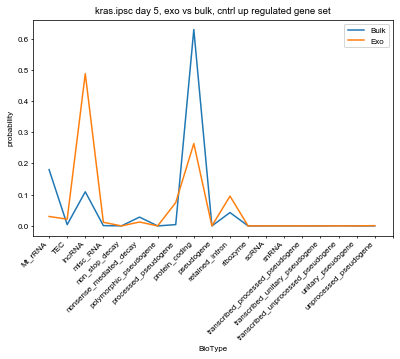

In [53]:
# create panel
figureWidthInInches = 5
figureHeightInInches = 3
fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))
panel = mplu.createPanelSameSizeAsFig(fig)

# select data to plot
DF = bioTypeProbDF.loc[:, upDataSets]
legendLabels = [s[len("up"):] for s in upDataSets]
title = "kras.ipsc day 5, exo vs bulk, cntrl up regulated gene set"
PlotProbMass(panel, DF, legendLabels, title)
#panel.save()

## Create biotype plots for CIRM application june 2022
we only want to plot non-zero probablities. The bioTypeProbDF was create using Psudo counts. bioTypeCountDF only contains non zero counts

In [54]:
bioTypeCountDF

,upBulk,upExo,downBulk,downExo
BioType,,,,
Mt_rRNA,623810.922,114022.780,0.000000e+00,0.000
TEC,13933.666,81456.603,1.545629e+03,248.502
lncRNA,378417.392,1838377.070,1.082163e+06,17749.088
misc_RNA,3230.916,43955.708,6.300000e+01,12.000
non_stop_decay,514.723,5.000,4.582477e+03,17.994
nonsense_mediated_decay,97459.509,47130.381,1.119712e+06,10524.621
polymorphic_pseudogene,32.310,14.274,0.000000e+00,0.000
processed_pseudogene,14402.492,281640.623,1.204385e+04,49.565
protein_coding,2176350.066,994264.810,4.208466e+07,211023.052


In [55]:
colSums = bioTypeCountDF.sum()
bioTypeProbNoPsudoCountsDF = bioTypeCountDF / colSums
bioTypeProbNoPsudoCountsDF

,upBulk,upExo,downBulk,downExo
BioType,,,,
Mt_rRNA,0.180333,0.030261,0.000000,0.000000
TEC,0.004028,0.021618,0.000034,0.000866
lncRNA,0.109394,0.487894,0.023559,0.061818
misc_RNA,0.000934,0.011666,0.000001,0.000042
non_stop_decay,0.000149,0.000001,0.000100,0.000063
nonsense_mediated_decay,0.028174,0.012508,0.024377,0.036656
polymorphic_pseudogene,0.000009,0.000004,0.000000,0.000000
processed_pseudogene,0.004164,0.074746,0.000262,0.000173
protein_coding,0.629146,0.263872,0.916211,0.734971


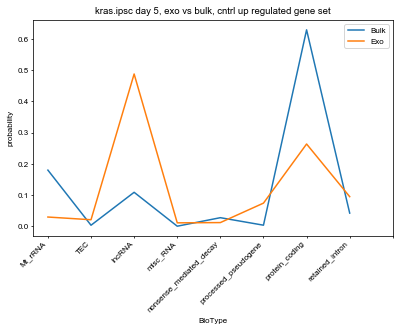

In [62]:
isGreaterThan1PercentTypes = (bioTypeProbNoPsudoCountsDF.loc[:,'upBulk'] > 0.01) \
                                | (bioTypeProbNoPsudoCountsDF.loc[:, 'upExo'] > 0.01)

bioTypePlotDF = bioTypeProbNoPsudoCountsDF.loc[isGreaterThan1PercentTypes, :]
# create panel
figureWidthInInches = 5
figureHeightInInches = 3
fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))
panel = mplu.createPanelSameSizeAsFig(fig)

# select data to plot
legendLabels = [s[len("up"):] for s in upDataSets]
title = "kras.ipsc day 5, exo vs bulk, cntrl up regulated gene set"
PlotProbMass(panel, bioTypePlotDF.loc[:, upDataSets], legendLabels, title)
plt.savefig("../img/kras.ipsc_day_5-exo_vs_bulk-cntrl_up_regulated_gene_set.png", bbox_inches='tight', dpi=600)

## End Create biotype plots for CIRM application june 2022

In [18]:
# aedwip
# is down regulated useful? can we use this to prove exosome payload is not just a random sample

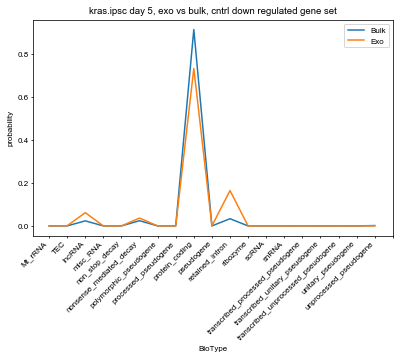

In [19]:
# create panel
figureWidthInInches = 5
figureHeightInInches = 3
fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))
panel = mplu.createPanelSameSizeAsFig(fig)

# select data to plot
DF = bioTypeProbDF.loc[:, downDataSets]
legendLabels = [s[len("down"):] for s in downDataSets]
title = "kras.ipsc day 5, exo vs bulk, cntrl down regulated gene set"
PlotProbMass(panel, DF, legendLabels, title)

## CDS cumlative distribution  Function

In [20]:
bioTypeCDF_DF = np.cumsum(bioTypeProbDF)
bioTypeCDF_DF.tail()

,upBulk,upExo,downBulk,downExo
BioType,,,,
transcribed_processed_pseudogene,0.999346,0.998745,0.998218,0.999665
transcribed_unitary_pseudogene,0.999383,0.998813,0.998222,0.999672
transcribed_unprocessed_pseudogene,0.999929,0.999115,0.998322,0.999760
unitary_pseudogene,0.999934,0.999167,0.998322,0.999763
unprocessed_pseudogene,1.000000,1.000000,1.000000,1.000000


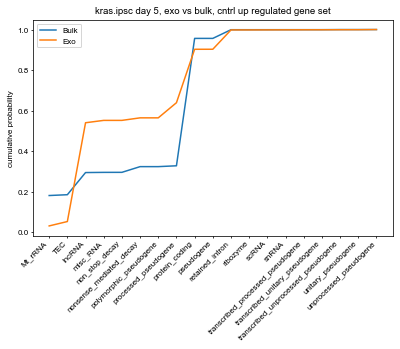

In [21]:
# create panel
figureWidthInInches = 5
figureHeightInInches = 3
fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))
panel = mplu.createPanelSameSizeAsFig(fig)

# select data to plot
DF = bioTypeCDF_DF.loc[:, upDataSets]
legendLabels = [s[len("up"):] for s in upDataSets]
title = "kras.ipsc day 5, exo vs bulk, cntrl up regulated gene set"
PlotCumulativeProbablity(panel, DF, legendLabels, title)
#panel.save()

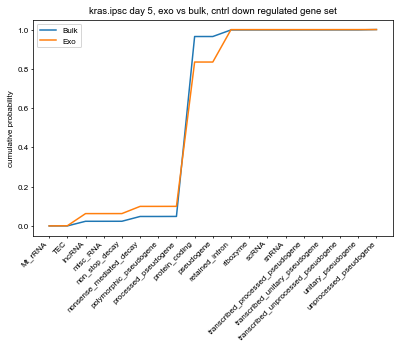

In [22]:
# create panel
figureWidthInInches = 5
figureHeightInInches = 3
fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))
panel = mplu.createPanelSameSizeAsFig(fig)

# select data to plot
DF = bioTypeCDF_DF.loc[:, downDataSets]
legendLabels = [s[len("down"):] for s in downDataSets]
title = "kras.ipsc day 5, exo vs bulk, cntrl down regulated gene set"
PlotCumulativeProbablity(panel, DF, legendLabels, title)
#panel.save()

In [23]:
diffSeries = bioTypeCDF_DF.loc[:,"upBulk"] - bioTypeCDF_DF.loc[:,"upExo"] 
selectRows = diffSeries.abs() > 0.01
DF = bioTypeCDF_DF.loc[selectRows, upDataSets]
DF["bulk - exo"] = bioTypeCDF_DF.loc[:,"upBulk"] - bioTypeCDF_DF.loc[:,"upExo"]
DF

,upBulk,upExo,bulk - exo
BioType,,,
Mt_rRNA,0.180332,0.030261,0.150071
TEC,0.184361,0.051879,0.132481
lncRNA,0.293754,0.539771,-0.246017
misc_RNA,0.294689,0.551437,-0.256748
non_stop_decay,0.294838,0.551439,-0.256601
nonsense_mediated_decay,0.323012,0.563947,-0.240935
polymorphic_pseudogene,0.323021,0.563951,-0.240930
processed_pseudogene,0.327185,0.638697,-0.311511
protein_coding,0.956328,0.902567,0.053760


In [24]:
diffSeries = bioTypeCDF_DF.loc[:,"downBulk"] - bioTypeCDF_DF.loc[:,"downExo"] 
selectRows = diffSeries.abs() > 0.01
DF = bioTypeCDF_DF.loc[selectRows, downDataSets]
DF["bulk - exo"] = bioTypeCDF_DF.loc[:,"downBulk"] - bioTypeCDF_DF.loc[:,"downExo"]
DF

,downBulk,downExo,bulk - exo
BioType,,,
lncRNA,0.023593,0.062690,-0.039097
misc_RNA,0.023595,0.062735,-0.039141
non_stop_decay,0.023694,0.062801,-0.039107
nonsense_mediated_decay,0.048071,0.099459,-0.051387
polymorphic_pseudogene,0.048071,0.099462,-0.051391
processed_pseudogene,0.048333,0.099638,-0.051305
protein_coding,0.964544,0.834564,0.129980
pseudogene,0.964544,0.834567,0.129977


## Kolmogorov-Smirnov test
Compare probability distributions

In [25]:
# The distribution is assumed to be continuous.
# If the KS statistic is small or the p-value is high, then we cannot reject the 
# hypothesis that the distributions of the two samples are the same.
# default is 2 sided

# KS is crude. If there is a difference there probably is a true difference else test probably
# just to weak to determine if diff or not

# exo vs bulk up regulated gene set
ksstat, pvalue = ks_2samp(bioTypeCountDF.loc[:, "upBulk"], bioTypeCountDF.loc[:, "upExo"])
print("exo vs bulk: up regulated gene set ks stat:{:2.4f} p-value:{:2.4f}".format(ksstat, pvalue))

exo vs bulk: up regulated gene set ks stat:0.2632 p-value:0.5379


In [26]:
# exo vs bulk down regulated gene set
ksstat, pvalue = ks_2samp(bioTypeCountDF.loc[:, "downBulk"], bioTypeCountDF.loc[:, "downExo"])
print("exo vs bulk: down regulated gene set ks stat:{:2.4f} p-value:{:2.4f}".format(ksstat, pvalue))

exo vs bulk: down regulated gene set ks stat:0.3158 p-value:0.3057


In [27]:
bioTypeCountDF.head()

,upBulk,upExo,downBulk,downExo
BioType,,,,
Mt_rRNA,623810.922,114022.780,0.000,0.000
TEC,13933.666,81456.603,1545.629,248.502
lncRNA,378417.392,1838377.070,1082162.734,17749.088
misc_RNA,3230.916,43955.708,63.000,12.000
non_stop_decay,514.723,5.000,4582.477,17.994


### Use permutation test to calculate k-s test p-value
TODO: how come permutation test produces a different p-value than ks_2samp?

In [28]:
# %%time

# shuffleParallelList is a hack
# numItterations = 10000
# ksSimulator = MonteCarlo( numItterations, 
#                          kolmogorovSmirnovStat, 
#                          shuffleFunc=shuffleParallelList )

# bulkUpSeries = bioTypeCountDF.loc[:, "upBulk"] 
# exoUpSeries  = bioTypeCountDF.loc[:, "upExo"]
# pvalue = ksSimulator.permutationTest(bulkUpSeries, exoUpSeries)
# print("exo vs bulk: up regulated gene set permutation test Kolmogorov-Smirnov test p-value:{:2.4f}".format(pvalue))

# bulkDownSeries = bioTypeCountDF.loc[:, "downBulk"] 
# exoDownSeries  = bioTypeCountDF.loc[:, "downExo"]
# pvalue = ksSimulator.permutationTest(bulkDownSeries, exoDownSeries)
# print("exo vs bulk: down regulated gene set permutation test Kolmogorov-Smirnov test p-value:{:2.4f}".format(pvalue))

##  Cross Entropy
Measures "how close to probability distributions are". It is not a distance measurement. I.E. it is not symetric. 

let p = true probablity distribution

let q = predicted probablity distribution

If 
    two distributions are the same the cross entropy equals the entropy
else
    "cross entroy" will be greater than the entropy by some number of bits

"relative entropy" is the amount the cross entropy exceeds the entropy. This is also known as the "kl divergance" or the "Kullback–Leibler divergence"

"cross entropy" = entropy + "Kullback–Leibler divergence"

ref:
- [A Short Introduction to Entropy, Cross-Entropy and KL-Divergence](https://www.youtube.com/watch?v=ErfnhcEV1O8)
- [Visual Information Theory](https://colah.github.io/posts/2015-09-Visual-Information/#:~:text=Cross%2Dentropy%20isn't%20symmetric.&text=Well%2C%20cross%2Dentropy%20gives%20us,than%20the%20entropy%20of%20p.)

In [29]:
%%time
# we only have at most something 44 biotype possible biotypes
# numSignifigantDigits=5 will set the simulated sample size to 10**5
# this should be more than accurate enough for our purpose
numItterations = 1000
numSignifigantDigits=5
klSimulator = kldMonteCarlo( numItterations, numSignifigantDigits)

bulkUpSeries = bioTypeProbDF.loc[:, "upBulk"] 
exoUpSeries  = bioTypeProbDF.loc[:, "upExo"] 

KLStat, pvalue = klSimulator.permutationTest(bulkUpSeries, exoUpSeries)
print("exo vs bulk: up regulated gene set Kullback–Leibler divergence:{:2.4f} p-value:{:2.4f}"
      .format(KLStat, pvalue))

exo vs bulk: up regulated gene set Kullback–Leibler divergence:0.9709 p-value:1.0000
CPU times: user 1min 56s, sys: 1.02 s, total: 1min 57s
Wall time: 1min 57s


In [30]:
%%time
bulkDownSeries = bioTypeProbDF.loc[:, "downBulk"] 
exoDownSeries  = bioTypeProbDF.loc[:, "downExo"]
KKLStat = entropy(bulkDownSeries, exoDownSeries, base=2)
KKLStat = entropy(bulkUpSeries, exoUpSeries, base=2)

numItterations = 1000
numSignifigantDigits=5
klSimulatorX = kldMonteCarlo( numItterations, numSignifigantDigits)
KLStat, pvalue = klSimulatorX.permutationTest(bulkDownSeries, exoDownSeries)
print("exo vs bulk: down regulated gene set Kullback–Leibler divergence:{:2.4f} p-value:{:2.4f}"
      .format(KLStat, pvalue))

exo vs bulk: down regulated gene set Kullback–Leibler divergence:0.1727 p-value:1.0000
CPU times: user 1min 53s, sys: 1.01 s, total: 1min 54s
Wall time: 1min 54s


## old conrol p-values
```
klSimulator = MonteCarlo( numItterations, 
                         kullbackLeiblerStat, 
                         shuffleFunc=shuffleParallelList )
                         
exo vs bulk: up regulated gene set Kullback–Leibler divergence:0.9709 p-value:0.7778
exo vs bulk: down regulated gene set Kullback–Leibler divergence:0.1727 p-value:0.0091
```

In [31]:
#bulkDownSeries
# print(bulkDownSeries)
# print(bulkDownSeries.sum())

In [32]:
#exoDownSeries
# exoDownSeries

In [33]:
(bulkDownSeries - exoDownSeries).abs().sum()

0.36599134303217773

In [34]:
aedwip save

SyntaxError: invalid syntax (<ipython-input-34-b3ac89463ee1>, line 1)

## Explore the distribution of by by type

In [ ]:
def selectBioTypeDistribution(df, bioType) :
    '''
    returns a pandas series of NumReads + psudo count
    
    arguments:
        df: data frame with a column named 'BioType'
        bioType: a string. examples "lncRNA" or "miRNA"
    '''
    # create a logical for each transcript
    isBT = df.loc[:,"BioType"] == bioType

    # multiplying by isBT ensures each transcript will have a count
    psudoCount = 1
    retSeries = df.loc[:, "NumReads"] * isBT + psudoCount
    return retSeries
  
bt = "lncRNA"
aedwipDF[bt] = selectBioTypeDistribution(aedwipDF, bt)
aedwipDF